In [278]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [279]:
import os, sys
path = os.getcwd()
while not path.endswith('research'):    
    path = os.path.abspath(os.path.join(path, '../'))
sys.path.append(path)
sys.path.append('C:\git\statslib')
import statslib as stb
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import warnings
warnings.filterwarnings("ignore")
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [280]:
import statsmodels.api as sm

In [281]:
import numpy as np
from datetime import datetime, date
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import time
from copy import deepcopy
from pandas.tseries.offsets import DateOffset
import seaborn as sns

In [282]:
from gmt.fom.gas.shared.utils.common import *
from gmt.fom.gas.shared.utils.dframe import *

In [283]:
from gmt.fom.gas.shared.models.stpb.data.mongo import MongoAdapter

In [284]:
figsize=(9*1.6, 9)

In [285]:
def save_to_path(f_name):
    _path = r'C:/git/gmt-fom-gas-research/sandbox/alexs/short_term_power_burn'
    return os.path.join(_path, f_name + '.csv')

In [286]:
def get_fourier_series(timeIndex,K):
    m = 7
    d = 1
    fourier_series = pd.DataFrame({'date':timeIndex})
    fourier_series = fourier_series.set_index(pd.RangeIndex(1,len(timeIndex)+1))

    for i in range(1, K+1):
        fourier_series[f'S{i}-{m}'] = np.sin(2 * i * np.pi * d *fourier_series.index/ m)
        fourier_series[f'C{i}-{m}'] = np.cos(2 * i * np.pi * d *fourier_series.index/ m)
    fourier_series = fourier_series.drop(columns=['date'])
    fourier_series.index = timeIndex
    return fourier_series

# CONSTANTS

In [287]:
YEARS = 3

In [288]:
FORECAST_HORIZON = 28

In [289]:
R_DATA_PATH =  r'C:\git\gmt-fom-gas-research\sandbox\alexs\short_term_power_burn\R\data'

# DATA

In [290]:
myData = MongoAdapter()
dataDM = myData.load_design_matrix()

t_out_time = dataDM.index[-FORECAST_HORIZON:].min(); t_out_time
t_out_sample = dataDM.index[-2*FORECAST_HORIZON:].min();  t_out_sample
t_start = t_out_time - DateOffset(years=YEARS)

mask = (dataDM.index>=t_start) & (dataDM.index<t_out_sample)
dataDM = dataDM[mask]


#removing leap year for 365 exactly
# leap_year_index = dataDM[(dataDM.index.month==2) & (dataDM.index.day==29)].index; leap_year_index
# dataDM = dataDM[~dataDM.index.isin(leap_year_index)]

#adding trend explicitely
dataDM['trend'] = range(1, len(dataDM.index)+1)

# monday_thursday vs. the rest
dataDM['weekday'] = dataDM.index.weekday
dataDM['weekday'] = dataDM['weekday'].apply(lambda t: t+1)
dataDM = dataDM.join(pd.get_dummies(dataDM['weekday'], prefix='day'))
dataDM['monday_thursday'] = dataDM['weekday'].apply(lambda v: 'yes' if v>=1 and v<5 else 'no')
dataDM = dataDM.join(pd.get_dummies(dataDM['monday_thursday'], prefix='mo_th'))

#fourier series
K = 3
dataDM = dataDM.join(get_fourier_series(dataDM.index,K))

In [291]:
(dataDM.index.min(), dataDM.index.max())

(Timestamp('2018-01-18 00:00:00'), Timestamp('2020-12-20 00:00:00'))

In [292]:
ddff(dataDM.head())

clean_spreads  curve_103234271  curve_103234272  curve_103234276  \
day                                                                            
2018-01-18       5.344688        27.245454         9.203636         9.554545   
2018-01-19       5.344688        26.378182        10.099091         9.554545   
2018-01-20       5.344688        26.133636         9.644545         9.554545   
2018-01-21       4.553188        25.620000         8.810909         9.554545   
2018-01-22       6.247422        27.275454        10.224545         9.554545   

            curve_103234278  curve_103234281  dark_spreads        gas  \
day                                                                     
2018-01-18         7.163636        23.090909     -0.842963  74.658089   
2018-01-19         7.163636        23.090909     -0.842963  71.675932   
2018-01-20         7.163636        25.709091     -0.842963  81.416621   
2018-01-21         7.163636        25.709091     -1.353429  60.167415   
2018-01-22         7.163636        25.709091      0.148997  63.819148   

               precip  temperature  wind  trend  weekday  day_1  day_2  day_3  \
day                                                                             
2018-01-18   3.893333     4.913636  4.89      1        4      0      0      0   
2018-01-19   3.200000     2.881818  3.96      2        5      0      0      0   
2018-01-20   2.786667     2.186364  2.57      3        6      0      0      0   
2018-01-21  10.440000     3.300000  3.12      4        7      0      0      0   
2018-01-22   1.626667     7.013636  3.86      5        1      1      0      0   

            day_4  day_5  day_6  day_7 monday_thursday  mo_th_no  mo_th_yes  \
day                                                                           
2018-01-18      1      0      0      0             yes         0          1   
2018-01-19      0      1      0      0              no         1          0   
2018-01-20      0      0      1      0              no         1          0   
2018-01-21      0      0      0      1              no         1          0   
2018-01-22      0      0      0      0             yes         0          1   

                S1-7      C1-7      S2-7      C2-7      S3-7      C3-7  
day                                                                     
2018-01-18  0.781831  0.623490  0.974928 -0.222521  0.433884 -0.900969  
2018-01-19  0.974928 -0.222521 -0.433884 -0.900969 -0.781831  0.623490  
2018-01-20  0.433884 -0.900969 -0.781831  0.623490  0.974928 -0.222521  
2018-01-21 -0.433884 -0.900969  0.781831  0.623490 -0.974928 -0.222521  
2018-01-22 -0.974928 -0.222521  0.433884 -0.900969  0.781831  0.623490

In [293]:
dependent_var = ['gas']; dependent_var

['gas']

In [294]:
covariates = ['clean_spreads', 'dark_spreads', 'precip', 'temperature', 'wind', 'trend',
             'curve_103234271','curve_103234272','curve_103234276','curve_103234278','curve_103234281']; '| '.join(covariates)

'clean_spreads| dark_spreads| precip| temperature| wind| trend| curve_103234271| curve_103234272| curve_103234276| curve_103234278| curve_103234281'

In [295]:
fourier_cols =  [k for k in dataDM if k.startswith('S') or k.startswith('C')]; '| '.join(fourier_cols)

'S1-7| C1-7| S2-7| C2-7| S3-7| C3-7'

In [296]:
days_cols = [v for v in dataDM.columns if v.startswith('day_')]; '| '.join(days_cols)

'day_1| day_2| day_3| day_4| day_5| day_6| day_7'

In [297]:
categorical_cols = [v for v in dataDM.columns if v.startswith('mo_')]; '| '.join(categorical_cols)

'mo_th_no| mo_th_yes'

In [298]:
aux_cols = ['monday_thursday', 'weekday']; aux_cols

['monday_thursday', 'weekday']

In [299]:
assert sorted(dependent_var + covariates + fourier_cols + days_cols + categorical_cols + aux_cols) == sorted(dataDM.columns)

In [300]:
# categorical: remove the last level
try:
    days_cols.remove('day_7')
    categorical_cols.remove('mo_th_no')
except Exception as e:
    print(e.args[0])
    pass

# Design Matrix

In [301]:
y = dataDM[dependent_var]; f = stb.transforms.identical(); y.head(1)

gas
day                  
2018-01-18  74.658089

In [302]:
stb.stat_tests.test_kpss(f(y))

H0: observable time series is stationary around a constant

Results of KPSS Test:
Test Statistic            0.960716
p-value                   0.010000
Lags Used                22.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Can NOT reject H0


In [303]:
stb.stat_tests.test_adf(f(y))

H0: unit root present in the time series

Results of Dickey-Fuller Test:
Test Statistic                   -4.168722
p-value                           0.000744
#Lags Used                       21.000000
Number of Observations Used    1044.000000
Critical Value (1%)              -3.436629
Critical Value (5%)              -2.864312
Critical Value (10%)             -2.568246
dtype: float64

p-value 0.0007 is less alpha 0.01 => Reject H0


***

In [304]:
gs = dict()

In [305]:
g1 = stb.transforms.identical(); 
gs.update(dict(zip(covariates, [g1]*len(covariates))))

In [306]:
g2 = stb.transforms.identical(); 
gs.update(dict(zip(categorical_cols, [g2]*len(categorical_cols))))
gs.update(dict(zip(fourier_cols, [g2]*len(fourier_cols))))
gs.update(dict(zip(days_cols, [g2]*len(days_cols))))

In [307]:
gs.update(dict(trend=stb.transforms.identical()))

In [308]:
X = dataDM[covariates + categorical_cols + fourier_cols + days_cols]; X.head(2)

clean_spreads  dark_spreads    precip  temperature  wind  trend  \
day                                                                           
2018-01-18       5.344688     -0.842963  3.893333     4.913636  4.89      1   
2018-01-19       5.344688     -0.842963  3.200000     2.881818  3.96      2   

            curve_103234271  curve_103234272  curve_103234276  \
day                                                             
2018-01-18        27.245454         9.203636         9.554545   
2018-01-19        26.378182        10.099091         9.554545   

            curve_103234278  ...      S2-7      C2-7      S3-7      C3-7  \
day                          ...                                           
2018-01-18         7.163636  ...  0.974928 -0.222521  0.433884 -0.900969   
2018-01-19         7.163636  ... -0.433884 -0.900969 -0.781831  0.623490   

            day_1  day_2  day_3  day_4  day_5  day_6  
day                                                   
2018-01-18      0      0      0      1      0      0  
2018-01-19      0      0      0      0      1      0  

[2 rows x 24 columns]

In [309]:
DM = stb.DesignMatrix(y=y, X=X, f=f, gs=gs, add_const=True)

In [310]:
DM.plot(drop_names = categorical_cols + fourier_cols + days_cols )

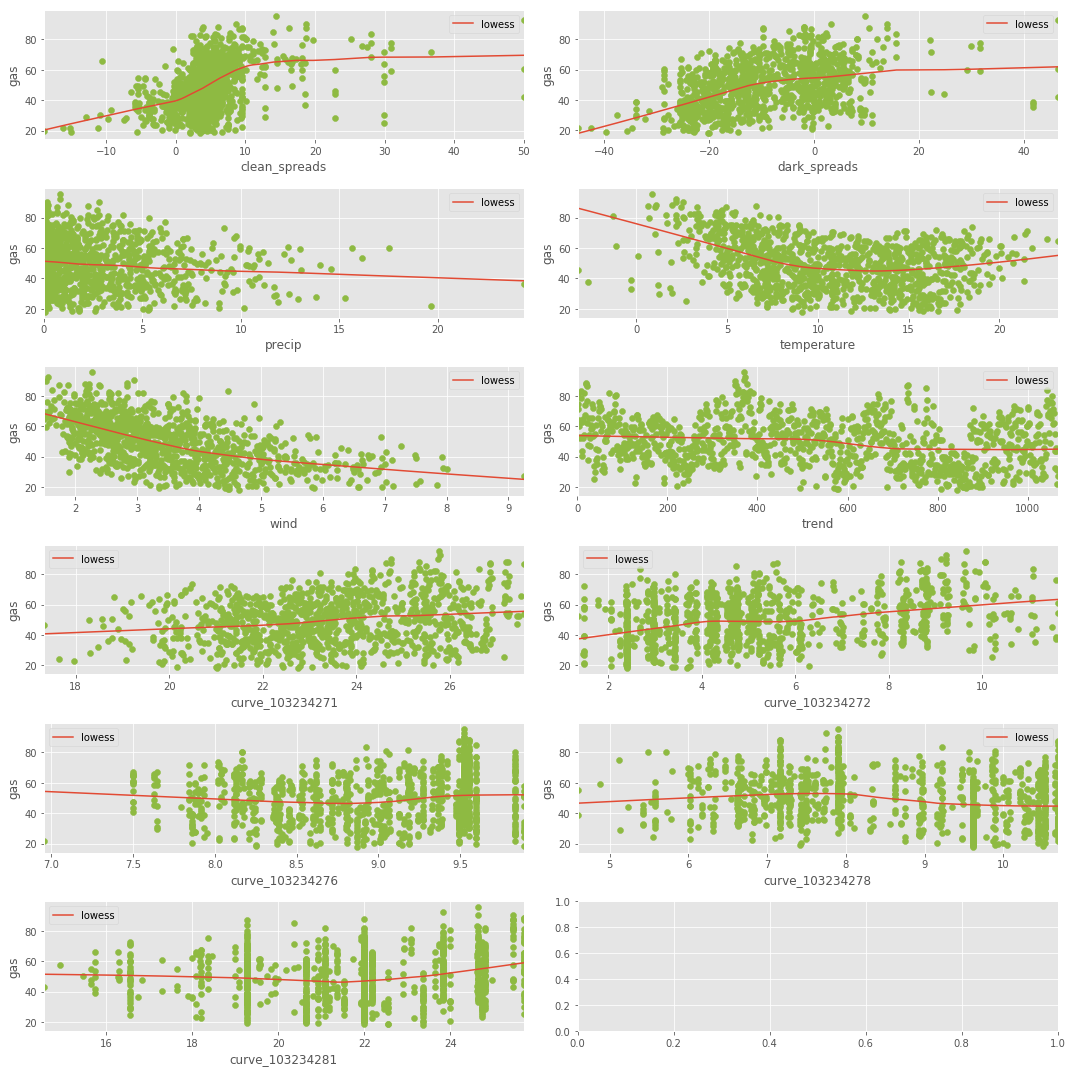

In [311]:
DM.plot_scatter_lowess(drop_names=categorical_cols + fourier_cols + days_cols)

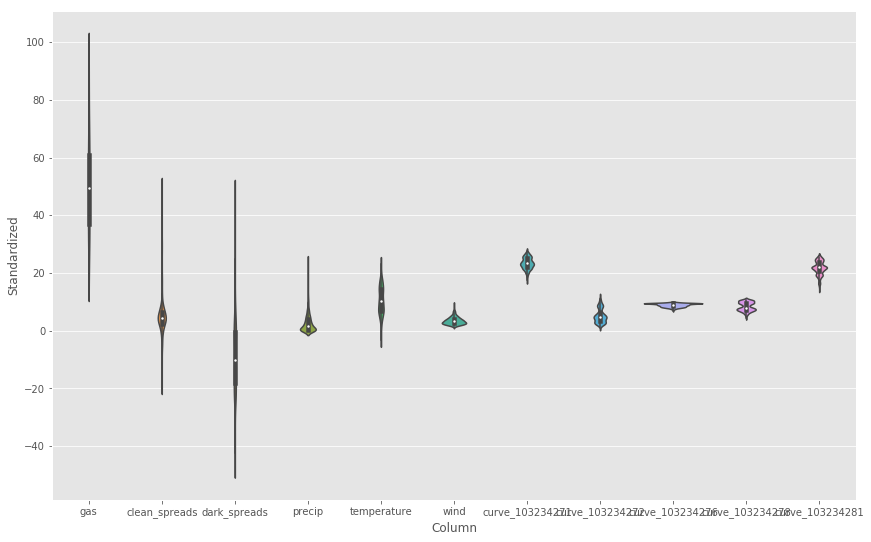

In [312]:
fig, ax = plt.subplots(figsize=figsize)
_ = DM.dm[['v']+DM.x_to_g([c for c in covariates if c!='trend'])].rename(columns=DM.names).melt(var_name='Column', value_name='Standardized')
sns.violinplot(x="Column", y="Standardized", data=_, ax=ax)
plt.show()

## Grid Search based on BIC

In [313]:
from itertools import product
from functools import partial

powerset = partial(stb.utils.common.powerset, skip_empty_set=True)
nms = [DM._inv_names.get(k) for k in covariates]
results = []
grid = list(powerset(nms))
N = len(grid)
i=0
for elem in grid:
    print(f'{N-i}', end='| ')
    nm = ['const']  + list(elem) + DM.x_to_g(fourier_cols) + DM.x_to_g(categorical_cols) #+  DM.x_to_g(days_cols)
    try:
        gc = stb.GeneralCalibrator(sm.OLS, dict())
        nDM = deepcopy(DM)
        nDM.gX = nDM.gX[nm]
        gm = stb.GeneralModel(gc, nDM)
        gm.fit(range(nDM.n))
        results.append([elem, gm.fitted.bic, nm])
    except Exception as e:
        print(e.args[0])
        continue
    i+=1
df_res = pd.DataFrame(results, columns=['elem', 'metric', 'config']).sort_values(
    by=['metric'], ascending=True)[['config', 'metric']]
df_res.head(5)

specification = df_res.head(1)['config'].values.tolist()[0]; '| '.join(map(DM.names.get, specification))


2047| 2046| 2045| 2044| 2043| 2042| 2041| 2040| 2039| 2038| 2037| 2036| 2035| 2034| 2033| 2032| 2031| 2030| 2029| 2028| 2027| 2026| 2025| 2024| 2023| 2022| 2021| 2020| 2019| 2018| 2017| 2016| 2015| 2014| 2013| 2012| 2011| 2010| 2009| 2008| 2007| 2006| 2005| 2004| 2003| 2002| 2001| 2000| 1999| 1998| 1997| 1996| 1995| 1994| 1993| 1992| 1991| 1990| 1989| 1988| 1987| 1986| 1985| 1984| 1983| 1982| 1981| 1980| 1979| 1978| 1977| 1976| 1975| 1974| 1973| 1972| 1971| 1970| 1969| 1968| 1967| 1966| 1965| 1964| 1963| 1962| 1961| 1960| 1959| 1958| 1957| 1956| 1955| 1954| 1953| 1952| 1951| 1950| 1949| 1948| 1947| 1946| 1945| 1944| 1943| 1942| 1941| 1940| 1939| 1938| 1937| 1936| 1935| 1934| 1933| 1932| 1931| 1930| 1929| 1928| 1927| 1926| 1925| 1924| 1923| 1922| 1921| 1920| 1919| 1918| 1917| 1916| 1915| 1914| 1913| 1912| 1911| 1910| 1909| 1908| 1907| 1906| 1905| 1904| 1903| 1902| 1901| 1900| 1899| 1898| 1897| 1896| 1895| 1894| 1893| 1892| 1891| 1890| 1889| 1888| 1887| 1886| 1885| 1884| 1883| 1882| 1881

| 606| 605| 604| 603| 602| 601| 600| 599| 598| 597| 596| 595| 594| 593| 592| 591| 590| 589| 588| 587| 586| 585| 584| 583| 582| 581| 580| 579| 578| 577| 576| 575| 574| 573| 572| 571| 570| 569| 568| 567| 566| 565| 564| 563| 562| 561| 560| 559| 558| 557| 556| 555| 554| 553| 552| 551| 550| 549| 548| 547| 546| 545| 544| 543| 542| 541| 540| 539| 538| 537| 536| 535| 534| 533| 532| 531| 530| 529| 528| 527| 526| 525| 524| 523| 522| 521| 520| 519| 518| 517| 516| 515| 514| 513| 512| 511| 510| 509| 508| 507| 506| 505| 504| 503| 502| 501| 500| 499| 498| 497| 496| 495| 494| 493| 492| 491| 490| 489| 488| 487| 486| 485| 484| 483| 482| 481| 480| 479| 478| 477| 476| 475| 474| 473| 472| 471| 470| 469| 468| 467| 466| 465| 464| 463| 462| 461| 460| 459| 458| 457| 456| 455| 454| 453| 452| 451| 450| 449| 448| 447| 446| 445| 444| 443| 442| 441| 440| 439| 438| 437| 436| 435| 434| 433| 432| 431| 430| 429| 428| 427| 426| 425| 424| 423| 422| 421| 420| 419| 418| 417| 416| 415| 414| 413| 412| 411| 410| 409| 408| 407

'const| clean_spreads| precip| temperature| wind| curve_103234271| curve_103234272| curve_103234281| S1-7| C1-7| S2-7| C2-7| S3-7| C3-7| mo_th_yes'

In [314]:
specification = DM.g_to_x(specification)

In [315]:
specification

['const',
 'clean_spreads',
 'precip',
 'temperature',
 'wind',
 'curve_103234271',
 'curve_103234272',
 'curve_103234281',
 'S1-7',
 'C1-7',
 'S2-7',
 'C2-7',
 'S3-7',
 'C3-7',
 'mo_th_yes']

# Cross-validation

In [316]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=6, test_size=FORECAST_HORIZON)
splits = [(train_idx, test_idx) for train_idx, test_idx in tscv.split(DM.dm.index)]

In [317]:
metric = stb.metrics.root_mean_squared_error

## Grid Search based on Cross Validation Error

In [318]:
gc = stb.GeneralCalibrator(sm.RLM, dict())
nDM = deepcopy(DM)
nDM.gX = nDM.gX[DM.x_to_g(specification)]
gm = stb.GeneralModel(gc, nDM)
cv = stb.CrossValidation(gm, splits, metric)
cv_m, cv_std = cv.run(False)

y_range = nDM.y.max() - nDM.y.min();
print(f'CV_error/range: {cv_m/y_range*100:.2f}% | (range: {y_range:.0f})')

CV_error: 8.93, CV_std: 1.20 | (7.73  10.13)
CV_error/range: 11.54% | (range: 77)


In [319]:
gc = stb.GeneralCalibrator(sm.WLS, dict())
nDM = deepcopy(DM)
nDM.gX = nDM.gX[DM.x_to_g(specification)]
gm = stb.GeneralModel(gc, nDM)
cv = stb.CrossValidation(gm, splits, metric)
cv_m, cv_std = cv.run(False)

y_range = nDM.y.max() - nDM.y.min();
print(f'CV_error/range: {cv_m/y_range*100:.2f}% | (range: {y_range:.0f})')

CV_error: 8.98, CV_std: 1.24 | (7.75  10.22)
CV_error/range: 11.61% | (range: 77)


In [320]:
gc = stb.GeneralCalibrator(sm.OLS, dict())
nDM = deepcopy(DM)
nDM.gX = nDM.gX[DM.x_to_g(specification)]
gm = stb.GeneralModel(gc, nDM)
cv = stb.CrossValidation(gm, splits, metric)
cv_m, cv_std = cv.run(False)

y_range = nDM.y.max() - nDM.y.min();
print(f'CV_error/range: {cv_m/y_range*100:.2f}% | (range: {y_range:.0f})')

CV_error: 8.98, CV_std: 1.24 | (7.75  10.22)
CV_error/range: 11.61% | (range: 77)


## In sample

In [321]:
specification

['const',
 'clean_spreads',
 'precip',
 'temperature',
 'wind',
 'curve_103234271',
 'curve_103234272',
 'curve_103234281',
 'S1-7',
 'C1-7',
 'S2-7',
 'C2-7',
 'S3-7',
 'C3-7',
 'mo_th_yes']

                            OLS Regression Results                            
Dep. Variable:                      v   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     151.0
Date:                Fri, 23 Apr 2021   Prob (F-statistic):          6.87e-240
Time:                        16:00:21   Log-Likelihood:                -3857.2
No. Observations:                1066   AIC:                             7744.
Df Residuals:                    1051   BIC:                             7819.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         55.8774      6.056      9.226      0.0

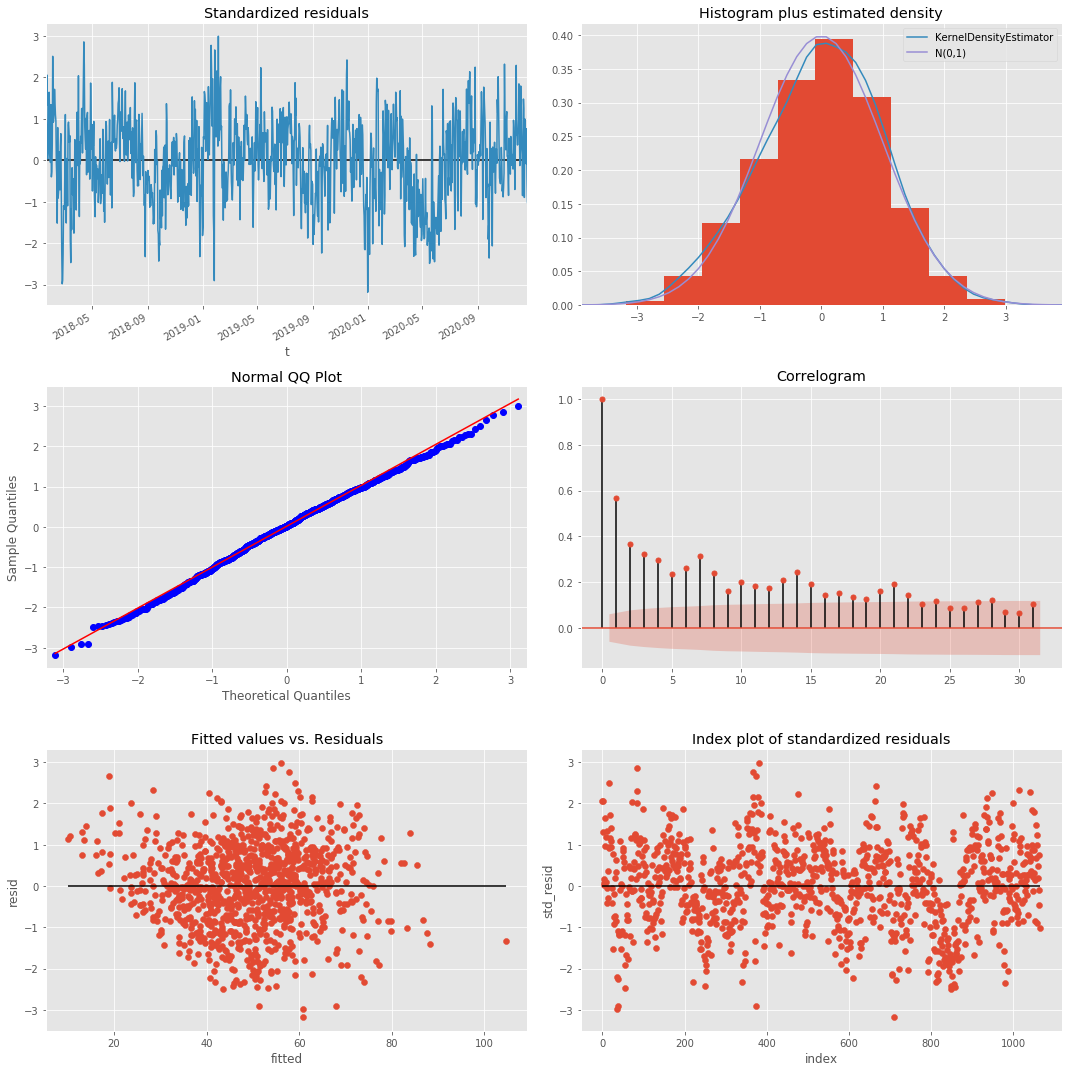

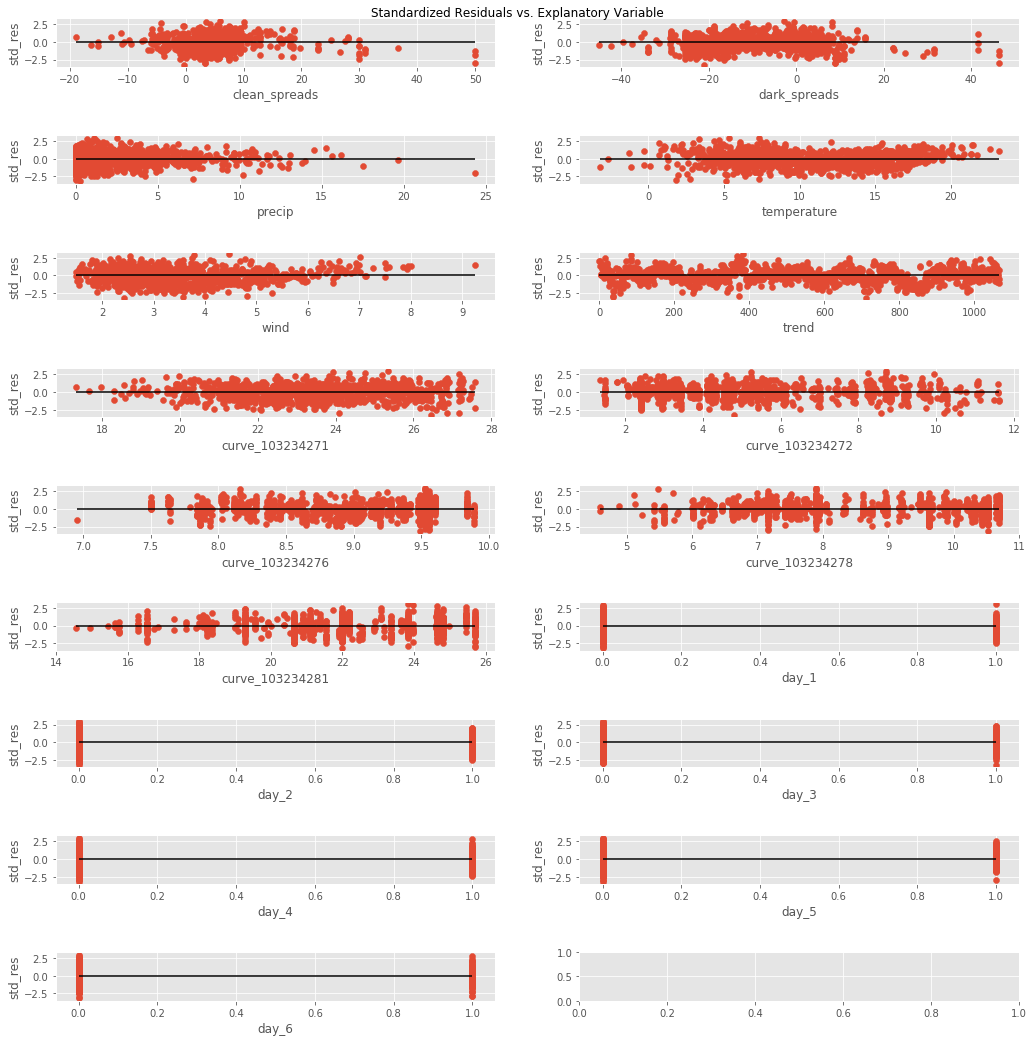

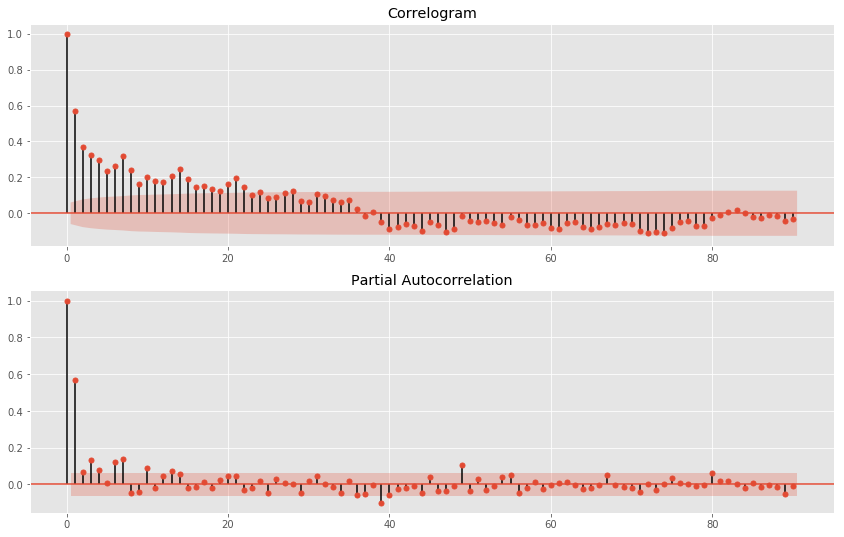

In [322]:
nDM = deepcopy(DM)
nDM.gX = nDM.gX[DM.x_to_g(specification)]
gm = stb.GeneralModel(gc, nDM)
gm.fit(range(DM.n))
gm.forecast(range(DM.n))
print(gm.fitted.summary())
gm.plot_diagnostics(drop_names=categorical_cols+fourier_cols)
stb.stat_plots.plot_acf_pcf(gm.std_residuals, kwargs_acf={'lags': 90}, kwargs_pacf={'lags':90})

NOBS = gm.fitted.nobs

Error: 9.01965605


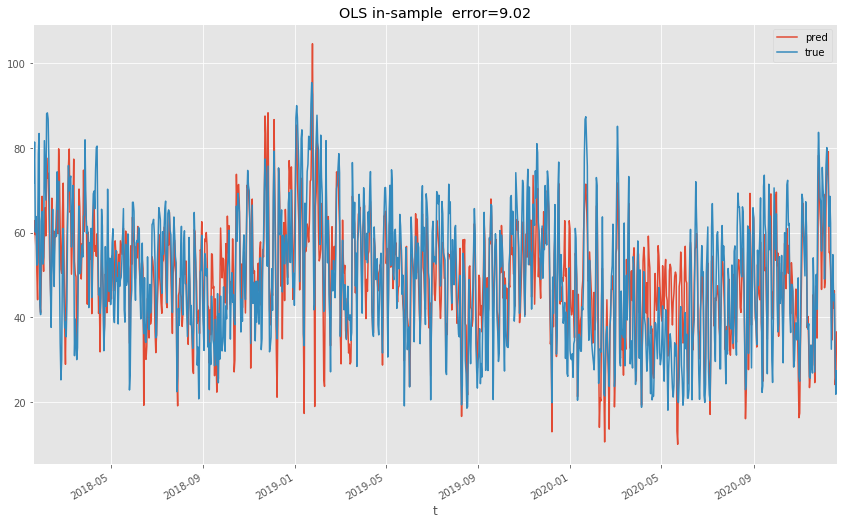

In [323]:
exog = DM.gX[DM.x_to_g(specification)]
v_hat = gm.fitted.predict(exog=exog)
y_hat = DM.f.inv(v_hat, y0=DM.dm.y[DM.dm.index.max()])
in_sample_error = metric(DM.y.loc[y_hat.index], y_hat)
print(f'Error: {in_sample_error:.8f}')

fig, ax = plt.subplots(figsize=figsize)
y_hat.plot(ax=ax)
DM.y.loc[y_hat.index].plot(ax=ax)
ax.legend(['pred', 'true', 'hist'])
title = f'OLS in-sample  error={in_sample_error:.2f}'
ax.set_title(title)
plt.savefig(r'C:\temp\{}.png'.format(title), bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [324]:
 DM.gX[DM.x_to_g(specification)].tail()

const        g1        g3         g4    g5         g7        g8  \
t                                                                             
2020-12-16    1.0  3.338657  7.320000   7.672727  4.91  23.254545  2.672727   
2020-12-17    1.0  2.933020  8.473333   8.186364  4.39  24.019091  2.672727   
2020-12-18    1.0  2.933020  9.626667  11.031818  6.23  23.260909  3.131818   
2020-12-19    1.0  2.933020  4.280000   8.913636  5.29  22.579091  3.131818   
2020-12-20    1.0 -3.251601  3.320000   6.895455  3.97  22.615454  2.400000   

                  g11           g13       g14           g15       g16  \
t                                                                       
2020-12-16  17.636363 -9.749279e-01 -0.222521  4.338837e-01 -0.900969   
2020-12-17  19.272727 -7.818315e-01  0.623490 -9.749279e-01 -0.222521   
2020-12-18  19.272727  1.961416e-14  1.000000  3.922831e-14  1.000000   
2020-12-19  19.272727  7.818315e-01  0.623490  9.749279e-01 -0.222521   
2020-12-20  19.272727  9.749279e-01 -0.222521 -4.338837e-01 -0.900969   

                     g17       g18  g12  
t                                        
2020-12-16  7.818315e-01  0.623490    1  
2020-12-17 -4.338837e-01 -0.900969    1  
2020-12-18 -2.822180e-13  1.000000    0  
2020-12-19  4.338837e-01 -0.900969    0  
2020-12-20 -7.818315e-01  0.623490    0

## Out of sample

In [325]:
data = myData.load_design_matrix()

outDataDM = deepcopy(data[(data.index>=t_out_sample) & (data.index<t_out_time)]);

outY = outDataDM[dependent_var]

#adding trend explicitely
outDataDM['trend'] = range(1, len(outDataDM.index)+1)

# monday_thursday vs. the rest
outDataDM['weekday'] = outDataDM.index.weekday
outDataDM['weekday'] = outDataDM['weekday'].apply(lambda t: t+1)
outDataDM = outDataDM.join(pd.get_dummies(outDataDM['weekday'], prefix='day'))
outDataDM['monday_thursday'] = outDataDM['weekday'].apply(lambda v: 'yes' if v>=1 and v<5 else 'no')
outDataDM = outDataDM.join(pd.get_dummies(outDataDM['monday_thursday'], prefix='mo_th'))

#fourier series
outDataDM = outDataDM.join(get_fourier_series(outDataDM.index, K))
covariates + categorical_cols + fourier_cols + days_cols
outX = outDataDM[covariates + categorical_cols  + fourier_cols + days_cols]; #outX.head(2)

outDM = stb.DesignMatrix(y=outY, X=outX, f=DM.f, gs=DM.gs, add_const=True)

exog = outDM.gX[outDM.x_to_g(specification)]

Error: 24.26585192


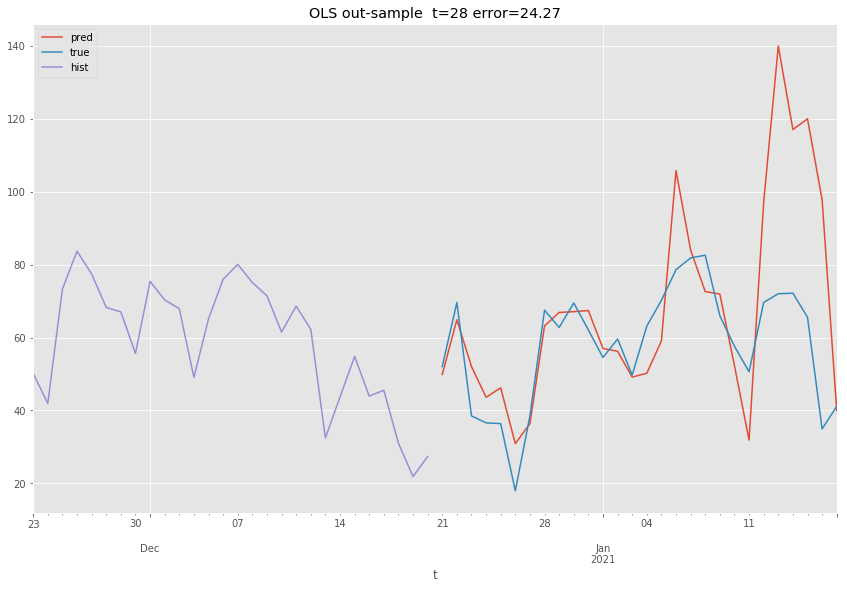

In [326]:
v_hat = gm.fitted.predict(exog=exog)

y_hat = DM.f.inv(v_hat, y0=DM.dm.y[DM.dm.index.max()])
out_of_sample_error = metric(outDM.y.loc[y_hat.index], y_hat)
print(f'Error: {out_of_sample_error:.8f}')

fig, ax = plt.subplots(figsize=figsize)
y_hat.plot(ax=ax)
outDM.y.loc[y_hat.index].plot(ax=ax)
DM.dm.y[-FORECAST_HORIZON:].plot(ax=ax)
ax.legend(['pred', 'true', 'hist'])
title = f'OLS out-sample  t={FORECAST_HORIZON} error={out_of_sample_error:.2f}'
ax.set_title(title)
plt.savefig(r'C:\temp\{}.png'.format(title), bbox_inches = 'tight', pad_inches = 0)
plt.show()

# Out of time

In [327]:
data = myData.load_design_matrix()

outTimeDataDM = deepcopy(data[int(-NOBS-FORECAST_HORIZON):])

outTimeY = outTimeDataDM[dependent_var]

#adding trend explicitely
outTimeDataDM['trend'] = range(1, len(outTimeDataDM.index)+1)

# monday_thursday vs. the rest
outTimeDataDM['weekday'] = outTimeDataDM.index.weekday
outTimeDataDM['weekday'] = outTimeDataDM['weekday'].apply(lambda t: t+1)
outTimeDataDM = outTimeDataDM.join(pd.get_dummies(outTimeDataDM['weekday'], prefix='day'))
outTimeDataDM['monday_thursday'] = outTimeDataDM['weekday'].apply(lambda v: 'yes' if v>=1 and v<5 else 'no')
outTimeDataDM = outTimeDataDM.join(pd.get_dummies(outTimeDataDM['monday_thursday'], prefix='mo_th'))

#fourier series
outTimeDataDM = outTimeDataDM.join(get_fourier_series(outTimeDataDM.index, K))

ddff(outTimeDataDM.head())

outX = outTimeDataDM[covariates + categorical_cols + days_cols + fourier_cols]; outX.head(2)

outTimeDM = stb.DesignMatrix(y=outTimeY, X=outX, f=f, gs=gs, add_const=True)

# ddff(outTimeDM.dm.head(2))

clean_spreads  curve_103234271  curve_103234272  curve_103234276  \
day                                                                            
2018-02-15       4.046223        27.445454        10.138182         9.554545   
2018-02-16       4.046223        26.898182         9.562727         9.554545   
2018-02-17       4.046223        26.601818         9.610000         9.554545   
2018-02-18       6.529748        26.170000         9.650909         9.554545   
2018-02-19       4.375822        27.154545         9.650909         9.554545   

            curve_103234278  curve_103234281  dark_spreads        gas  \
day                                                                     
2018-02-15         7.163636        25.709091       1.41325  47.294989   
2018-02-16         7.163636        25.709091       1.41325  58.501659   
2018-02-17         7.163636        25.709091       1.41325  60.792909   
2018-02-18         7.163636        25.709091       1.41325  59.184069   
2018-02-19         7.163636        25.709091       1.41325  74.377294   

              precip  temperature  wind  trend  weekday  day_1  day_2  day_3  \
day                                                                            
2018-02-15  0.733333     5.245455  4.94      1        4      0      0      0   
2018-02-16  1.000000     4.609091  3.27      2        5      0      0      0   
2018-02-17  1.226667     5.359091  2.70      3        6      0      0      0   
2018-02-18  2.426667     5.154545  2.07      4        7      0      0      0   
2018-02-19  2.440000     8.036364  2.48      5        1      1      0      0   

            day_4  day_5  day_6  day_7 monday_thursday  mo_th_no  mo_th_yes  \
day                                                                           
2018-02-15      1      0      0      0             yes         0          1   
2018-02-16      0      1      0      0              no         1          0   
2018-02-17      0      0      1      0              no         1          0   
2018-02-18      0      0      0      1              no         1          0   
2018-02-19      0      0      0      0             yes         0          1   

                S1-7      C1-7      S2-7      C2-7      S3-7      C3-7  
day                                                                     
2018-02-15  0.781831  0.623490  0.974928 -0.222521  0.433884 -0.900969  
2018-02-16  0.974928 -0.222521 -0.433884 -0.900969 -0.781831  0.623490  
2018-02-17  0.433884 -0.900969 -0.781831  0.623490  0.974928 -0.222521  
2018-02-18 -0.433884 -0.900969  0.781831  0.623490 -0.974928 -0.222521  
2018-02-19 -0.974928 -0.222521  0.433884 -0.900969  0.781831  0.623490

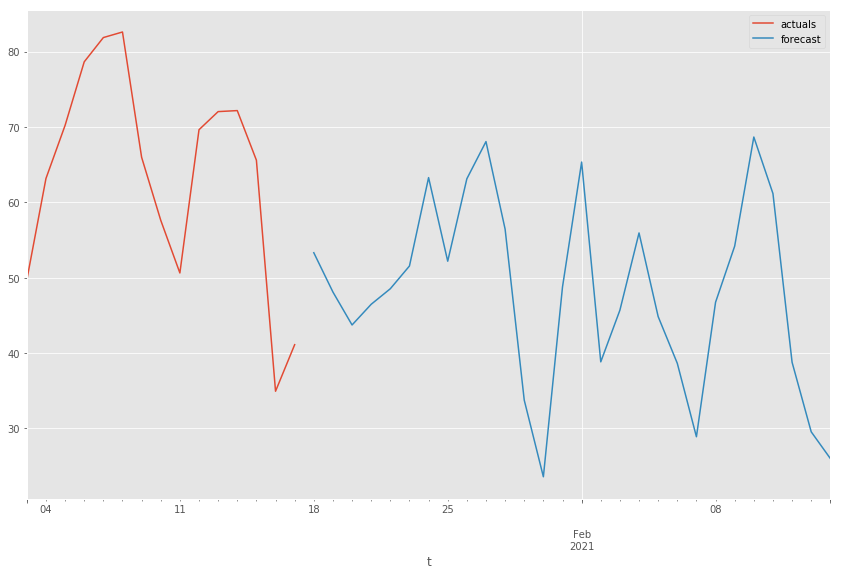

In [328]:
nDM = deepcopy(outTimeDM)
nDM.gX = nDM.gX[outTimeDM.x_to_g(specification)].rename(columns=outTimeDM.names)
gm = stb.GeneralModel(gc, nDM)
gm.fit(range(outTimeDM.n-FORECAST_HORIZON))

gm.forecast(range(outTimeDM.n-FORECAST_HORIZON, outTimeDM.n))

v_hat = gm.v_hat
y_hat = gm.y_hat

fig, ax = plt.subplots(figsize=figsize)
data.gas.iloc[:-(FORECAST_HORIZON)].iloc[-15:].plot(ax=ax)
y_hat.plot(ax=ax)
ax.legend(['actuals', 'forecast'])
plt.show()

In [329]:
print(gm.fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      v   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     138.3
Date:                Fri, 23 Apr 2021   Prob (F-statistic):          8.04e-227
Time:                        16:00:29   Log-Likelihood:                -3880.3
No. Observations:                1066   AIC:                             7791.
Df Residuals:                    1051   BIC:                             7865.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              67.0873      6.113     

## Benchmark from PointValue

# Summary

In [330]:
path = r'C:\git\gmt-fom-gas-research\sandbox\alexs\short_term_power_burn\results'
cfn = stb.utils.file.create_file_name

summary_dict = dict(zip(['YEARS',
'FORECAST_HORIZON',
'cv_m',
'cv_std',
'in_sample_error',
'out_of_sample_error'],
[YEARS,
FORECAST_HORIZON,
round(cv_m,2),
round(cv_std,4),
round(in_sample_error, 4),
round(out_of_sample_error,4)]))
summary_dict.update(dict(zip(specification, DM.g_to_x(specification))))
summary_dict.update(dict(cf=gc.cf.__name__))
transforms_dict = {k:v.__str__().split('transforms.')[1].split(' ')[0] for k,v in gs.items()}
summary_dict.update(dict(gs=transforms_dict))
summary_dict
pd.DataFrame.from_dict(summary_dict, orient='index').T.to_json(cfn(folder=path, extension='json', silent=False))

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\ashubert\Anaconda3\envs\gas_research\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\Users\ashubert\Anaconda3\envs\gas_research\lib\logging\handlers.py", line 394, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\Users\ashubert\Anaconda3\envs\gas_research\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'c:\\git\\gmt-fom-gas-research\\logs\\log_debug.txt' -> 'c:\\git\\gmt-fom-gas-research\\logs\\log_debug.txt.2021-03-22'
Call stack:
  File "C:\Users\ashubert\Anaconda3\envs\gas_research\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\ashubert\Anaconda3\envs\gas_research\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\ashubert\AppData\Roaming\Python\Python37\site

In [331]:
mySmartData = stb.SmartData()
mySmartData.acquire.from_folder(path)

mask = ['FORECAST_HORIZON', 'YEARS', 'cf', 'cv_m', 'cv_std', 'in_sample_error', 'out_of_sample_error' ]
pd.concat([mySmartData.get(name) for name in mySmartData.sourced.names]).reset_index(drop=True).sort_index(ascending=False)[mask].head(10)

FORECAST_HORIZON  YEARS       cf   cv_m  cv_std  in_sample_error  \
117                28      3      OLS   8.98  1.2358           9.0197   
116                28      3      OLS   8.98  1.2358           9.0197   
115                28      3      OLS   8.98  1.2358           9.0197   
114                28      3      OLS   8.98  1.2358           9.0197   
113                90      3  SARIMAX  10.37  2.4105           7.0443   
112                28      3      OLS   9.43  2.0782           9.1114   
111                28      3      OLS   9.43  2.0782           9.1114   
110                90      3  SARIMAX  10.37  2.4105           7.0443   
109                28      3      OLS   9.43  2.0782           9.1114   
108                28      3      OLS   9.43  2.0782           9.1114   

     out_of_sample_error  
117              24.2659  
116              50.1503  
115              50.1503  
114              50.1503  
113               7.2700  
112              16.6281  
111              16.6281  
110               7.2700  
109              16.6281  
108             249.5044